In [2]:
#Importing the sqlite data into python
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
import seaborn as sns
connection = sqlite3.connect('Northwind_small.sqlite')
cur = connection.cursor()
#cur.execute('''SELECT *  From Customer ;''').fetchall()

In [3]:
# Code to move the data from sql to a panda dataframe to ease working with
query = cur.execute("SELECT * From Customer")
cols = [column[0] for column in query.description]
results_cust= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

In [4]:
# verifying proper ingestion of data and data structure
results_cust.head(2)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745


In [5]:
#Code to see size of dataframe
results_cust.shape

(91, 11)

In [6]:
#Investigating another table to see the contents
query2 = cur.execute("SELECT * From [Order]")
cols = [column[0] for column in query2.description]
results_order= pd.DataFrame.from_records(data = query2.fetchall(), columns = cols)
results_order.head(2)
#results_order.shape

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


In [7]:
results_order.shape

(830, 14)

In [8]:
#Hypothesis 1: Null Hypothesis that discounts do not affect product sales discount!=f(sales); Alternative Hypothesis that discounts
#do affect sales discount=f(sales)
#

In [9]:
#Code to join the two SQL tables so i can create one df to work with
q = '''
SELECT [OrderDetail].Discount,[OrderDetail].Quantity
FROM [Order]
JOIN [OrderDetail]
ON OrderID = [Order].id;
'''

In [10]:
#Code to join the two SQL tables so i can create one df to work with
#q = '''
#SELECT [OrderDetail].ProductID,[OrderDetail].Discount,[OrderDetail].Quantity
#FROM [Order]
#JOIN [OrderDetail]
#ON OrderID = [Order].id;
#'''

In [11]:
intersect2 = cur.execute(q)
df_new = pd.DataFrame(intersect2.fetchall())
df_new.head(3)
#df_new.shape

,0,1
0,0.0,12
1,0.0,10
2,0.0,5


In [12]:
# Renaming the columns to make it easier to work with
df_new.columns = ['Discount','Quantity']
df_new.head()
df_new_mean= np.mean(df_new)
df_new_mean

Discount     0.056167
Quantity    23.812993
dtype: float64

In [62]:
#How many products where bought on discounts
#Creating table with only discount sales
df1_discount = df_new[df_new.Discount > 0]
df1_discount.head()
#df1_discount.describe()
#df1_discount.info()

,Discount,Quantity
6,0.15,35
7,0.15,15
8,0.05,6
9,0.05,15
11,0.05,40


In [63]:
df1_discount['Discount'].value_counts()

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64

In [14]:
#Checking the mean of the values
z= np.mean(df1_discount)
z

Discount     0.144439
Quantity    27.109785
dtype: float64

In [15]:
#How many products where bought not on discounts
#Creating table with only discount sales
df1_no_discount = df_new[df_new.Discount <= 0]
df1_no_discount.head()
#df1_discount.info()

,Discount,Quantity
0,0.0,12
1,0.0,10
2,0.0,5
3,0.0,9
4,0.0,40


In [16]:
#Checking the mean of the values
y =np.mean(df1_no_discount)
y
df1_no_discount.describe()

,Discount,Quantity
count,1317.0,1317.000000
mean,0.0,21.715262
std,0.0,17.507493
min,0.0,1.000000
25%,0.0,10.000000
50%,0.0,18.000000
75%,0.0,30.000000
max,0.0,130.000000


In [17]:
#Checking for normality
import scipy.stats as stat
stat.normaltest(df1_discount)
stat.normaltest(df1_no_discount)

NormaltestResult(statistic=array([  1.00443703, 544.57700456]), pvalue=array([6.05186553e-001, 5.57963738e-119]))

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


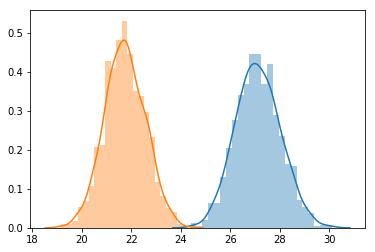

In [18]:
# create function to sample with replacement
def get_sample(df, n):
    sample = []
    indices = np.arange(len(df))
    while len(sample) != n:
        x = np.random.choice(df)
        sample.append(x)
    return sample

# create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)
# combine functions to create a sample distribution
# create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
       
    return sample_dist
# create sample distributions of sample mean for control and target
ctrl_sample = create_sample_distribution(df1_discount['Quantity'])
exp_sample = create_sample_distribution(df1_no_discount['Quantity'])
#plt.hist(ctrl_sample, normed = True, bins = 10)
#plt.hist(exp_sample, normed = True, bins = 10)
sns.distplot(ctrl_sample)
sns.distplot(exp_sample)

In [19]:
#ctrl_sample
#exp_sample
df1_discount.head(3)
np.mean(get_sample(df1_discount['Quantity'].values, 500))
#df1_discount['Quantity']

26.566

In [20]:
#Checking the mean of ctrl and exp samples
print (np.mean(ctrl_sample))
print (np.mean(exp_sample))

27.126614
21.737124


In [21]:
#Checking the variance
np.var(ctrl_sample)== np.var (exp_sample)

False

In [22]:
#testing the p-values
t, p = ttest_ind(ctrl_sample, exp_sample, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = 140.074  p = 0


In [23]:
#Based on the P-value > 0.05 above we reject the null hypothesis in favor of the alternative hypothesis.
#Discounts do affect sales.

In [64]:
#At what levels do discounts significantly affect the number of products sold
#df1_discount = df_new[df_new.Discount > 0]
#df1_discount.head()
from statsmodels.stats.multicomp import pairwise_tukeyhsd
t= df1_discount[df_new.Discount == 0.05]
v= df1_discount[df_new.Discount == 0.10]
q= df1_discount[df_new.Discount == 0.15]
r= df1_discount[df_new.Discount == 0.20]
w= df1_discount[df_new.Discount == 0.25]
s= df1_no_discount
#s= df1_discount[df_new.Discount == 0.35]
a=t[t.columns[1]]
b=q[q.columns[1]]
c=r[r.columns[1]]
d=s[s.columns[1]]
e=v[v.columns[1]]
f=w[w.columns[1]]
#c.head()
v = np.concatenate([a, b, c, d, e, f])
#print (a)
labels = ['0.05'] * len(a) + ['0.15'] * len(b) + ['0.20'] * len(c) + ['0'] * len(d) + ['0.10'] * len(e)+ ['0.25'] * len(f)  
#print(labels)
tukey_results = pairwise_tukeyhsd(v,labels,0.05)
print (tukey_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0     0.05   6.2955   2.0814 10.5097  True 
  0     0.10   3.5217  -0.8187  7.8622 False 
  0     0.15   6.6669   2.1352 11.1986  True 
  0     0.20   5.3096   0.8285  9.7907  True 
  0     0.25   6.525    1.954   11.096  True 
 0.05   0.10  -2.7738  -8.4504  2.9028 False 
 0.05   0.15   0.3714  -5.4528  6.1955 False 
 0.05   0.20   -0.986  -6.7708  4.7989 False 
 0.05   0.25   0.2294  -5.6253  6.0842 False 
 0.10   0.15   3.1452   -2.771  9.0613 False 
 0.10   0.20   1.7879  -4.0896  7.6653 False 
 0.10   0.25   3.0033   -2.943  8.9496 False 
 0.15   0.20  -1.3573  -7.3775  4.6628 False 
 0.15   0.25  -0.1419  -6.2292  5.9454 False 
 0.20   0.25   1.2154  -4.8343  7.2652 False 
---------------------------------------------


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [25]:
#Hypothesis 2: Is there a statistical difference in the number of products ordered from the Western Europe vs everything else
#null hypothesis is that there is no difference i.e Products (Western Europe)= Products (Eastern Europe)
#Alternative hypothesis is that there is a difference i.e Products (Western Europe)!= Products (Eastern Europe)

In [26]:
hyp2 = cur.execute (''' SELECT Region,Quantity
            FROM Customer
            LEFT JOIN [Order]
            ON Customer.Id
            LEFT JOIN OrderDetail
            ON OrderId;''')


In [27]:
#hyp2.fetchall()

In [28]:
#intersect3 = cur.execute(hyp2)
df_new2 = pd.DataFrame(hyp2.fetchall())
df_new2.columns = ['Region','Quantity']
#df_new2.head(10)
df_new2.describe()
#df_new2.shape

,Quantity
count,196105.000000
mean,23.812993
std,19.017681
min,1.000000
25%,10.000000
50%,20.000000
75%,30.000000
max,130.000000


In [29]:
#Create table with only western region
df_new2_2 = df_new2[df_new2['Region'] == "Western Europe"]
df_new2_2.shape

(60340, 2)

In [30]:
#Checking the shape of the data for the eastern region
df_new2_3 = df_new2[df_new2['Region'] == "Eastern Europe"]
df_new2_3.shape

(2155, 2)

In [31]:
#df_new2_2.describe()

In [32]:
np.mean((df_new2_2['Quantity']))
#df_new2_3.describe()

23.812993039443157

In [33]:
np.mean((df_new2_3['Quantity']))

23.812993039443157

In [34]:
df_new2_3['Quantity'].sum()
#/len(df_new2_3.index)

51317

In [35]:
len(df_new2_3.index)

2155

In [36]:
df_new2_2['Quantity'].sum()
#/len(df_new2_2.index)

1436876

In [37]:
len(df_new2_2.index)

60340

In [38]:
t, p = ttest_ind(df_new2_2['Quantity'],df_new2_3['Quantity'], equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = 0  p = 1


In [39]:
#Based on the P-value > 0.05 above we fail to reject the null hypothesis in favor of the alternative hypothesis.
#There is no difference in the number of products ordered between the Western and Eastern regions.

In [40]:
#Hypothesis 3: Is there a statistical difference between number of goods sold by Employee #1 Nancy Davalio and Micheal Suayma #6
#Null Hypothesis: Number of goods sold by Employee 1 = Number of goods sold by Employee 6
#Alternative Hypothesis: Number of goods sold by Employee 1 != Number of goods sold by Employee 6

In [41]:
hyp3 = cur.execute ('''SELECT [Order].EmployeeId,OrderDetail.ProductId,Quantity
            FROM [Order]
            JOIN OrderDetail
            ON OrderId;''')

In [42]:
df_new3 = pd.DataFrame(hyp3.fetchall())
df_new3.columns = ['EmployeeId','ProductId','Quantity']
df_new3.head(7)
#df_new.shape

,EmployeeId,ProductId,Quantity
0,5,11,12
1,6,11,12
2,4,11,12
3,3,11,12
4,4,11,12
5,3,11,12
6,5,11,12


In [43]:
#sorting to find total number of goods sold by Employees 1 
df_new3_emp1 = df_new3[df_new3.EmployeeId== 1]
#df1_no_discount = df_new[df_new.Discount <= 0]
df_new3_emp1.head()

,EmployeeId,ProductId,Quantity
10,1,11,12
22,1,11,12
27,1,11,12
37,1,11,12
44,1,11,12


In [44]:
#sorting to find total number of goods sold by Employees 6
df_new3_emp6 = df_new3[df_new3.EmployeeId== 6]
#df1_no_discount = df_new[df_new.Discount <= 0]
df_new3_emp6.head()

,EmployeeId,ProductId,Quantity
1,6,11,12
16,6,11,12
23,6,11,12
24,6,11,12
26,6,11,12


In [45]:
df_new3_emp1.describe()
#df_new3_emp6.describe

,EmployeeId,ProductId,Quantity
count,265065.0,265065.000000,265065.000000
mean,1.0,40.793039,23.812993
std,0.0,22.153919,19.017669
min,1.0,1.000000,1.000000
25%,1.0,22.000000,10.000000
50%,1.0,41.000000,20.000000
75%,1.0,60.000000,30.000000
max,1.0,77.000000,130.000000


In [46]:
df_new3_emp6.describe()

,EmployeeId,ProductId,Quantity
count,144385.0,144385.000000,144385.000000
mean,6.0,40.793039,23.812993
std,0.0,22.153954,19.017699
min,6.0,1.000000,1.000000
25%,6.0,22.000000,10.000000
50%,6.0,41.000000,20.000000
75%,6.0,60.000000,30.000000
max,6.0,77.000000,130.000000


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


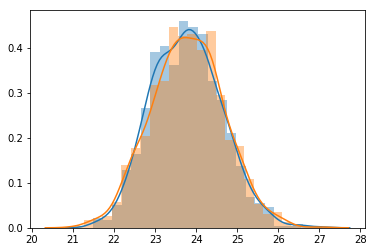

In [47]:
ctrl_sample1 = create_sample_distribution(df_new3_emp1['Quantity'])
exp_sample1 = create_sample_distribution(df_new3_emp6['Quantity'])
#plt.hist(ctrl_sample, normed = True, bins = 10)
#plt.hist(exp_sample, normed = True, bins = 10)
sns.distplot(ctrl_sample1)
sns.distplot(exp_sample1)

In [48]:
print (np.mean(ctrl_sample1))
print (np.mean(exp_sample1))

23.765896
23.79097


In [49]:
t, p = ttest_ind(ctrl_sample1, exp_sample1, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = -0.648631  p = 0.516651


In [50]:
#Based on the P-value > 0.05 above we fail to reject the null hypothesis in favor of the alternative hypothesis.
#There is no difference in the number of goods sold between Employee #1 and Employee #6

In [51]:
#hypothesis4: Is the mean freight price significantly different between Federal Shipping and Speedy Express?
#Null hypothesis there is no difference mfp(Federal Shipping)= mfp(Speedy Express)
#Alternative Hypothesis there is a difference mfp(Federal Shipping)!= mfp(Speedy Express)

In [52]:
hyp4 = cur.execute ('''SELECT CompanyName, [Order].Id, Freight
            FROM Shipper
            JOIN [Order]
            ON Shipper.Id= ShipVia;''')

In [53]:
df_new4 = pd.DataFrame(hyp4.fetchall())
df_new4.columns = ['CompanyName','OrderId','Freight']
df_new4.head(7)
#df_new.shape

,CompanyName,OrderId,Freight
0,Federal Shipping,10248,32.38
1,Speedy Express,10249,11.61
2,United Package,10250,65.83
3,Speedy Express,10251,41.34
4,United Package,10252,51.30
5,United Package,10253,58.17
6,United Package,10254,22.98


In [54]:
df_new4_fedship = df_new4[df_new4.CompanyName=='Federal Shipping']
df_new4_spex = df_new4[df_new4.CompanyName=='Speedy Express']
print (df_new4_fedship["Freight"].mean())
print (df_new4_spex["Freight"].mean())


80.44121568627443
65.00132530120482


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


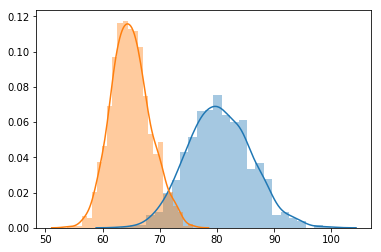

In [55]:
ctrl_sample2 = create_sample_distribution(df_new4_fedship['Freight'])
exp_sample2 = create_sample_distribution(df_new4_spex['Freight'])
#plt.hist(ctrl_sample, normed = True, bins = 10)
#plt.hist(exp_sample, normed = True, bins = 10)
sns.distplot(ctrl_sample2)
sns.distplot(exp_sample2)

In [56]:
t, p = ttest_ind(ctrl_sample2, exp_sample2, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = 76.1128  p = 0


In [57]:
#Based on the P-value < 0.05 above we reject the null hypothesis in favor of the alternative hypothesis.
#There is a difference in the mean freight price of shipping between Federal Shipping and express shipping .

In [58]:
#Business Recommendations
#1. Apply more discounts to boost sales selectively
#2. Stock the same amount of products in both Western and Eastern Regions
#3. Employee sales seem to be the same across the board. Implement training for all employees
#4. Profits can be improved by giving more shipments orders to Express shipping
